# <center>Common pitfalls in the interpretation of coefficients of linear models<center>

## The dataset: wages

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy as sp
import seaborn as sns
import warnings

warnings.filterwarnings("ignore")

from sklearn.datasets import fetch_openml

# as_frame=True ：将数据转为Pandas的DF类型
survey = fetch_openml(data_id=534, as_frame=True)

X = survey.data[survey.feature_names]
X.describe(include="all")

,EDUCATION,SOUTH,SEX,EXPERIENCE,UNION,AGE,RACE,OCCUPATION,SECTOR,MARR
count,534.000000,534,534,534.000000,534,534.000000,534,534,534,534
unique,NaN,2,2,NaN,2,NaN,3,6,3,2
top,NaN,no,male,NaN,not_member,NaN,White,Other,Other,Married
freq,NaN,378,289,NaN,438,NaN,440,156,411,350
mean,13.018727,NaN,NaN,17.822097,NaN,36.833333,NaN,NaN,NaN,NaN
std,2.615373,NaN,NaN,12.379710,NaN,11.726573,NaN,NaN,NaN,NaN
min,2.000000,NaN,NaN,0.000000,NaN,18.000000,NaN,NaN,NaN,NaN
25%,12.000000,NaN,NaN,8.000000,NaN,28.000000,NaN,NaN,NaN,NaN
50%,12.000000,NaN,NaN,15.000000,NaN,35.000000,NaN,NaN,NaN,NaN
75%,15.000000,NaN,NaN,26.000000,NaN,44.000000,NaN,NaN,NaN,NaN


In [2]:
# 注意，数据集包含分类变量和数值变量。之后在对数据集进行预处理时，我们需要考虑到这一点
X.head()

,EDUCATION,SOUTH,SEX,EXPERIENCE,UNION,AGE,RACE,OCCUPATION,SECTOR,MARR
0,8,no,female,21,not_member,35,Hispanic,Other,Manufacturing,Married
1,9,no,female,42,not_member,57,White,Other,Manufacturing,Married
2,12,no,male,1,not_member,19,White,Other,Manufacturing,Unmarried
3,12,no,male,4,not_member,22,White,Other,Other,Unmarried
4,12,no,male,17,not_member,35,White,Other,Other,Married


In [3]:
# 我们的预测目标:工资。工资被描述为每小时美元的浮点数
y = survey.target.values.ravel()
survey.target.head()

0    5.10
1    4.95
2    6.67
3    4.00
4    7.50
Name: WAGE, dtype: float64

In [4]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

首先，让我们通过观察变量分布以及它们之间的成对关系来获得一些见解。只使用数值变量。在下面的图中，每个点代表一个样本。

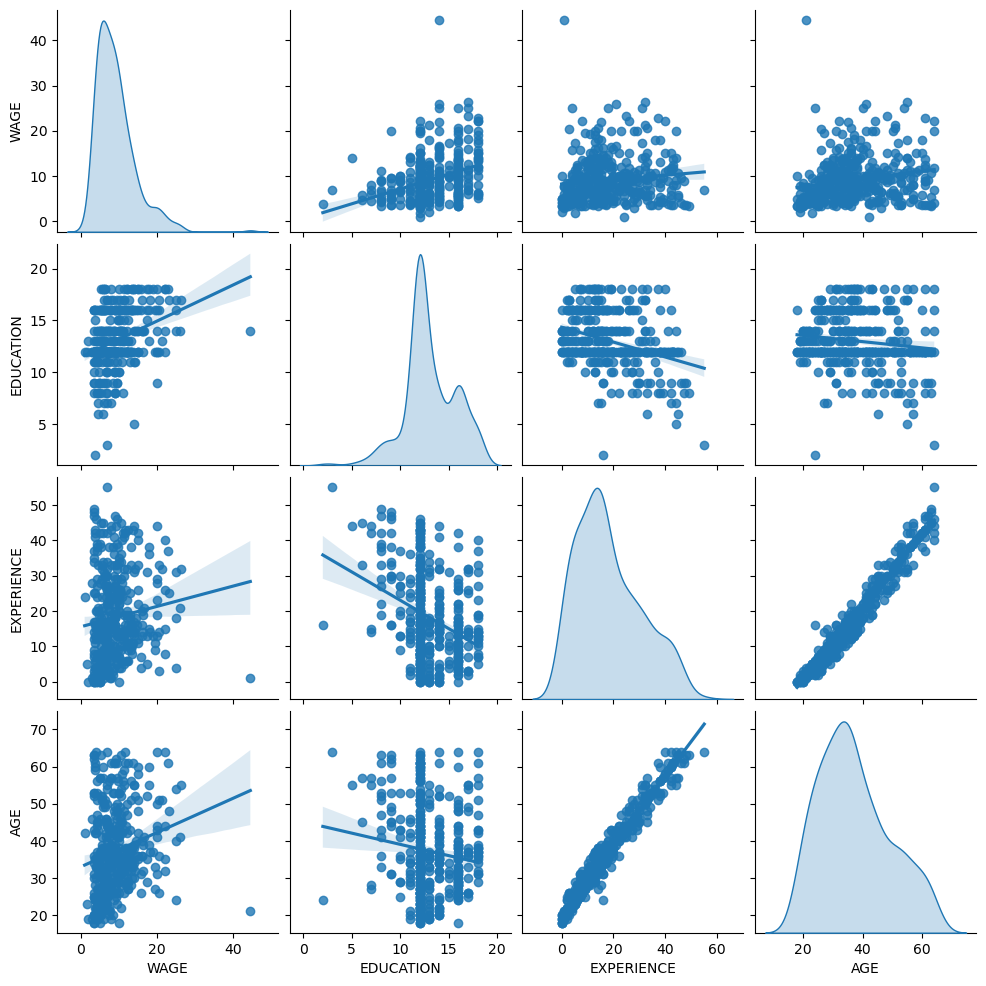

In [5]:
train_dataset = X_train.copy()
# print(train_dataset)
train_dataset.insert(0, "WAGE", y_train)

# kind='reg'：加回归线(默认值是scatter)， diag_kind：对角线绘制方式(hist/kde/None)
_ = sns.pairplot(train_dataset, kind="reg", diag_kind="kde")

## The machine-learning pipeline

To design our machine-learning pipeline, we first manually check the type of data that we are dealing with：

In [6]:
survey.data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 534 entries, 0 to 533
Data columns (total 10 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   EDUCATION   534 non-null    int64   
 1   SOUTH       534 non-null    category
 2   SEX         534 non-null    category
 3   EXPERIENCE  534 non-null    int64   
 4   UNION       534 non-null    category
 5   AGE         534 non-null    int64   
 6   RACE        534 non-null    category
 7   OCCUPATION  534 non-null    category
 8   SECTOR      534 non-null    category
 9   MARR        534 non-null    category
dtypes: category(7), int64(3)
memory usage: 17.3 KB


如前所述，数据集包含不同数据类型的列，我们需要对每种数据类型应用特定的预处理。特别地，如果分类变量不先被编码为整数，则不能包含在线性模型中。此外，为了避免类别型特征被视为有序值，我们需要对它们进行独热编码。我们的预处理器会：
* 独热编码(即按类别生成列)分类列，仅适用于非二元分类变量;
* 作为第一种方法(我们将在后面看到数值归一化如何影响我们的讨论)，保持数值原样。

In [7]:
from sklearn.compose import make_column_transformer
from sklearn.preprocessing import OneHotEncoder

categorical_columns = ["RACE", "OCCUPATION", "SECTOR", "MARR", "UNION", "SEX", "SOUTH"]
numerical_columns = ["EDUCATION", "EXPERIENCE", "AGE"]

preprocessor = make_column_transformer(
    (OneHotEncoder(drop="if_binary"), categorical_columns),
    remainder="passthrough",
    verbose_feature_names_out=False,  # avoid to prepend the preprocessor names
)

To describe the dataset as a linear model we use a ridge regressor with a very small regularization and to model the logarithm of the WAGE.

为了将数据集描述为线性模型，我们使用具有非常小正则化的岭回归器，并对工资的对数进行建模。

In [8]:
from sklearn.compose import TransformedTargetRegressor
from sklearn.linear_model import Ridge
from sklearn.pipeline import make_pipeline

model = make_pipeline(
    preprocessor,
    TransformedTargetRegressor(
        regressor=Ridge(alpha=1e-10), func=np.log10, inverse_func=sp.special.exp10
    ),
)

## Processing the dataset

In [9]:
model.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('onehotencoder',
                                                  OneHotEncoder(drop='if_binary'),
                                                  ['RACE', 'OCCUPATION',
                                                   'SECTOR', 'MARR', 'UNION',
                                                   'SEX', 'SOUTH'])],
                                   verbose_feature_names_out=False)),
                ('transformedtargetregressor',
                 TransformedTargetRegressor(func=<ufunc 'log10'>,
                                            inverse_func=<ufunc 'exp10'>,
                                            regressor=Ridge(alpha=1e-10)))])

In [10]:
from sklearn.metrics import PredictionErrorDisplay, median_absolute_error

mae_train = median_absolute_error(y_train, model.predict(X_train))
y_pred = model.predict(X_test)
mae_test = median_absolute_error(y_test, y_pred)
scores = {
    "MedAE on training set": f"{mae_train:.2f} $/hour",
    "MedAE on testing set": f"{mae_test:.2f} $/hour",
}

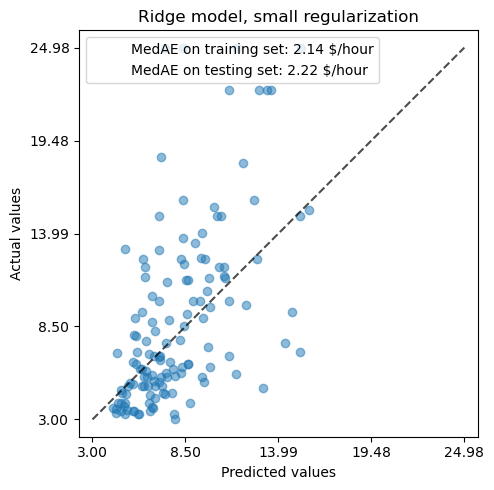

In [11]:
_, ax = plt.subplots(figsize=(5, 5))
display = PredictionErrorDisplay.from_predictions(
    y_test, y_pred, kind="actual_vs_predicted", ax=ax, scatter_kwargs={"alpha": 0.5}
)
ax.set_title("Ridge model, small regularization")
for name, score in scores.items():
    ax.plot([], [], " ", label=f"{name}: {score}")
ax.legend(loc="upper left")
# 固定布局,防止因为拉伸布局而使得lable重叠起来
plt.tight_layout()
# plt.show()

学习到的模型远远不是一个做出准确预测的好模型:当看上面的图时，这是很明显的，良好的预测应该位于黑色虚线上。

在下一节中，我们将解释模型的系数。虽然我们这样做，但我们应该记住，我们得出的任何结论都是关于我们构建的模型，而不是关于数据的真实(现实世界)生成过程。

## Interpreting coefficients: scale matters

First of all, we can take a look to the values of the coefficients of the regressor we have fitted.

首先，我们可以看看我们拟合的回归器的系数值。

In [12]:
feature_names = model[:-1].get_feature_names_out()

coefs = pd.DataFrame(
    model[-1].regressor_.coef_,
    columns=["Coefficients"],
    index=feature_names,
)

coefs

,Coefficients
RACE_Hispanic,-0.013530
RACE_Other,-0.009086
RACE_White,0.022583
OCCUPATION_Clerical,0.000052
OCCUPATION_Management,0.090535
OCCUPATION_Other,-0.025095
OCCUPATION_Professional,0.071971
OCCUPATION_Sales,-0.046629
OCCUPATION_Service,-0.091046
SECTOR_Construction,-0.000163


年龄系数表示为“美元/小时每生命年”，教育系数表示为“美元/小时每教育年”。系数的这种表示有利于明确模型的实际预测:年龄增加1年意味着减少0.030867美元/小时，而教育增加1年意味着增加0.054699美元/小时。另一方面，分类变量(如联合变量或性别变量)是一个维度上的数值，取值为0或1。它们的系数以美元/小时表示。然后，我们无法比较不同系数的大小，因为特征具有不同的自然尺度，因此由于它们的度量单位不同，因此值范围也不同。如果我们绘制系数，这一点会更明显。

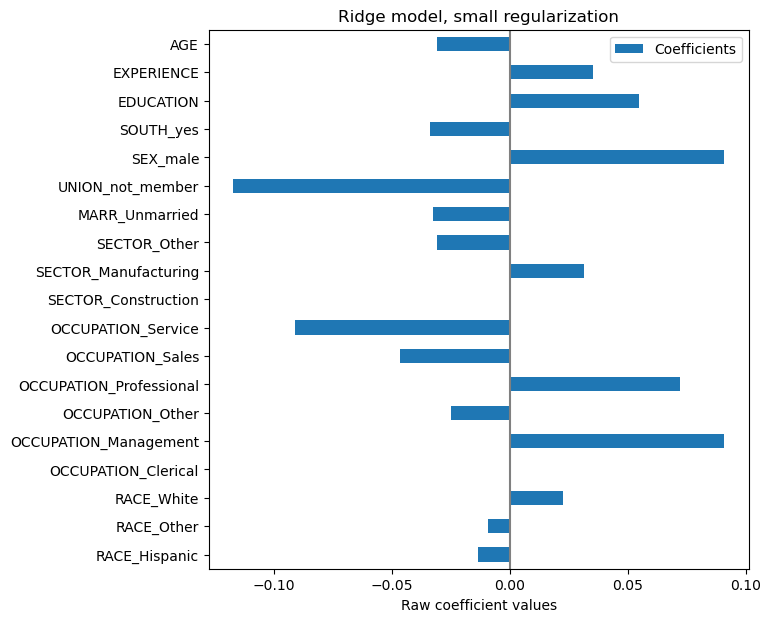

In [13]:
coefs.plot.barh(figsize=(9, 7))
plt.title("Ridge model, small regularization")
plt.axvline(x=0, color=".5")
plt.xlabel("Raw coefficient values")
plt.subplots_adjust(left=0.3)

事实上，从上图来看，决定工资的最重要因素似乎是变量UNION，即使我们的直觉可能告诉我们，EXPERIENCE 等变量应该有更大的影响。

通过系数图来衡量特征重要性可能会产生误导，因为其中一些特征在小范围内变化很大，而其他特征(如AGE)的变化很大，可能长达几十年。

如果我们比较不同特征的标准差，这是显而易见的。

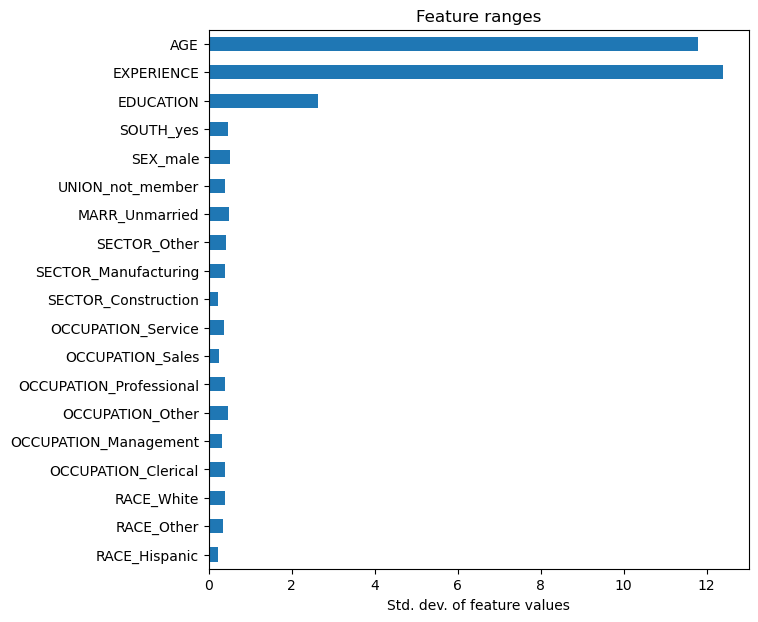

In [14]:
X_train_preprocessed = pd.DataFrame(
    model[:-1].transform(X_train), columns=feature_names
)

X_train_preprocessed.std(axis=0).plot.barh(figsize=(9, 7))
plt.title("Feature ranges")
plt.xlabel("Std. dev. of feature values")
plt.subplots_adjust(left=0.3)

将这些系数乘以相关特征的标准差，可以将所有系数缩减到同一度量单位。正如我们之后将看到的，这等价于将数值变量归一化为其标准差

通过这种方式，我们强调，在其他条件相同的情况下，特征的方差越大，输出上相应系数的权重就越大。

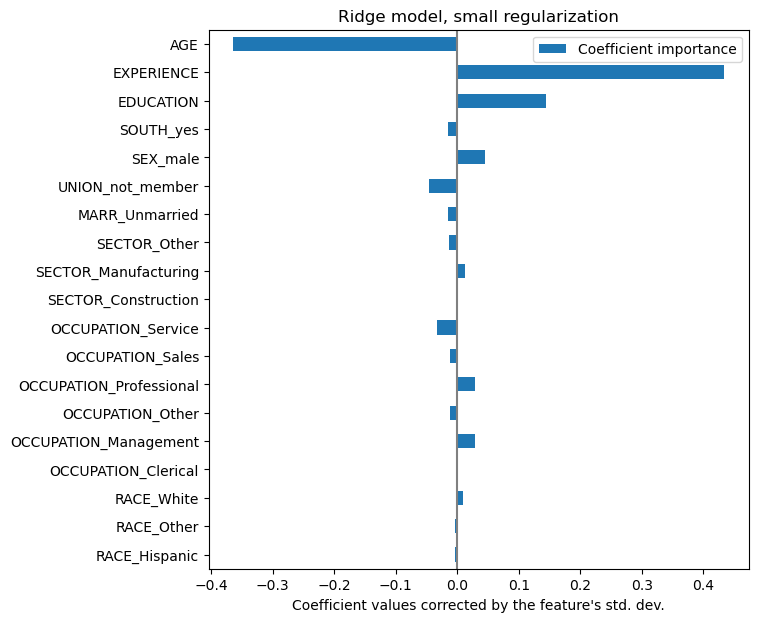

In [15]:
coefs = pd.DataFrame(
    model[-1].regressor_.coef_ * X_train_preprocessed.std(axis=0),
    columns=["Coefficient importance"],
    index=feature_names,
)
coefs.plot(kind="barh", figsize=(9, 7))
plt.xlabel("Coefficient values corrected by the feature's std. dev.")
plt.title("Ridge model, small regularization")
plt.axvline(x=0, color=".5")
plt.subplots_adjust(left=0.3)

现在系数已经缩放，我们可以安全地比较它们了。

> 提醒:为什么上面的图表明年龄的增加会导致工资的减少?为什么初始的成对图告诉我们相反的信息?


上面的图告诉我们当所有其他特征保持不变时，特定功能和目标之间的依赖关系，即条件依赖关系。当所有其他特征保持不变时，年龄的增加将导致工资的减少。相反，当所有其他特征保持不变时，经验的增加将导致工资的增加。此外，年龄、经验和教育是对模型影响最大的三个变量。

## Checking the variability of the coefficients

检查系数的可变性

我们可以通过交叉验证来检查系数的可变性:这是一种数据扰动(与重采样有关)。

如果系数在改变输入数据集时变化很大，则不能保证其坚固性，因此应该谨慎解释它们。

In [16]:
from sklearn.model_selection import RepeatedKFold, cross_validate

cv = RepeatedKFold(n_splits=5, n_repeats=5, random_state=0)
cv_model = cross_validate(
    model,
    X,
    y,
    cv=cv,
    return_estimator=True,
    n_jobs=2,
)

coefs = pd.DataFrame(
    [
        est[-1].regressor_.coef_ * est[:-1].transform(X.iloc[train_idx]).std(axis=0)
        for est, (train_idx, _) in zip(cv_model["estimator"], cv.split(X, y))
    ],
    columns=feature_names,
)

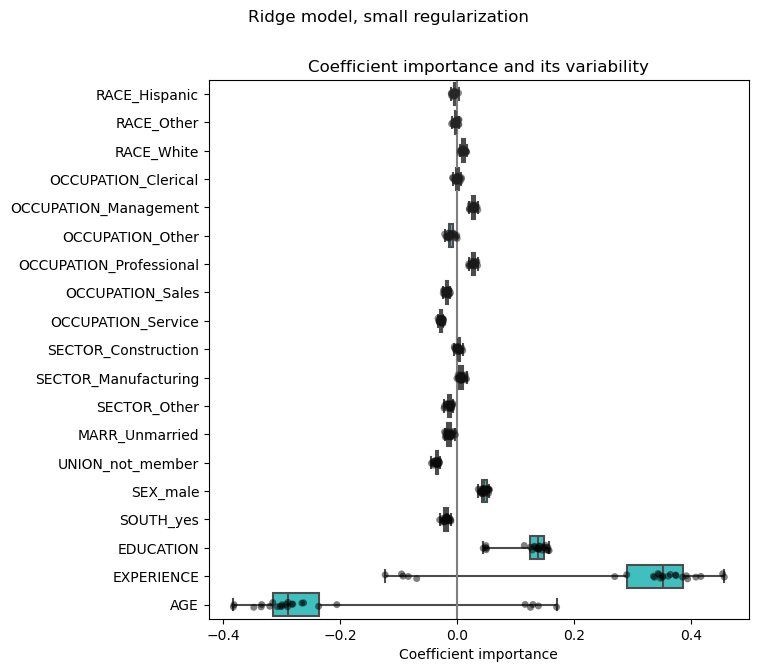

In [17]:
plt.figure(figsize=(9, 7))
sns.stripplot(data=coefs, orient="h", palette="dark:k", alpha=0.5)
sns.boxplot(data=coefs, orient="h", color="cyan", saturation=0.5, whis=10)
plt.axvline(x=0, color=".5")
plt.xlabel("Coefficient importance")
plt.title("Coefficient importance and its variability")
plt.suptitle("Ridge model, small regularization")
plt.subplots_adjust(left=0.3)

## The problem of correlated variables

相关变量的问题

AGE和EXPERIENCE系数受到强烈变异性的影响，这可能是由于两个特征之间的共线性:由于AGE和EXPERIENCE在数据中一起变化，它们的影响很难分开。

为了验证这种解释，我们绘制了年龄和经验系数的变异性。

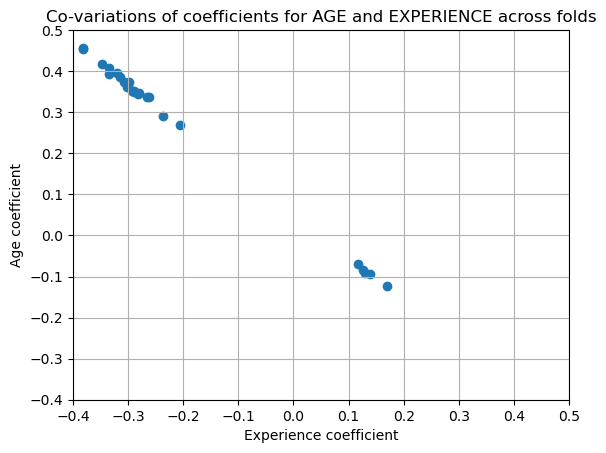

In [18]:
plt.ylabel("Age coefficient")
plt.xlabel("Experience coefficient")
plt.grid(True)
plt.xlim(-0.4, 0.5)
plt.ylim(-0.4, 0.5)
# 散点图
plt.scatter(coefs["AGE"], coefs["EXPERIENCE"])
_ = plt.title("Co-variations of coefficients for AGE and EXPERIENCE across folds")

两个区域被填充:当EXPERIENCE系数为正时，AGE系数为负，反之亦然。

为了更进一步，我们删除两个特征中的一个，并检查对模型稳定性的影响。响。

In [19]:
column_to_drop = ["AGE"]

cv_model = cross_validate(
    model,
    X.drop(columns=column_to_drop),
    y,
    cv=cv,
    return_estimator=True,
    n_jobs=2,
)

coefs = pd.DataFrame(
    [
        est[-1].regressor_.coef_
        * est[:-1].transform(X.drop(columns=column_to_drop).iloc[train_idx]).std(axis=0)
        for est, (train_idx, _) in zip(cv_model["estimator"], cv.split(X, y))
    ],
    columns=feature_names[:-1],
)

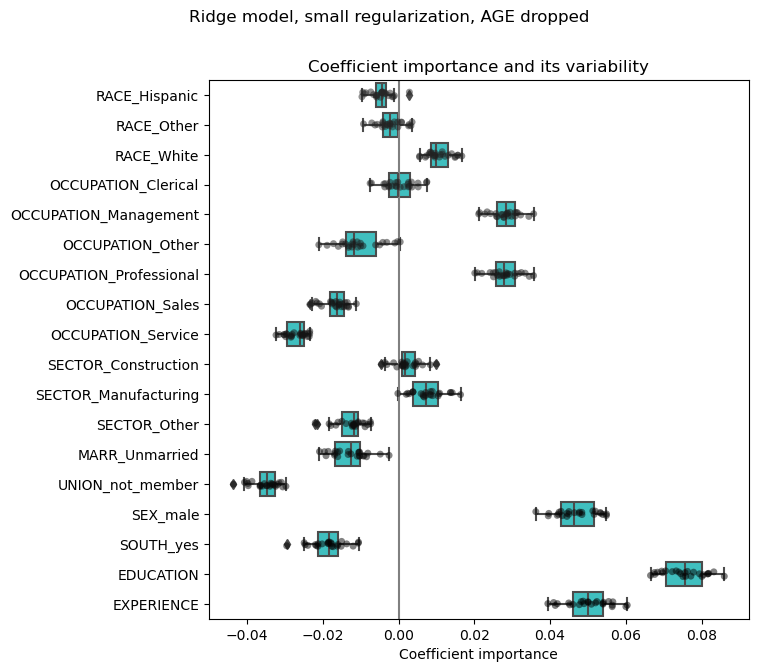

In [20]:
plt.figure(figsize=(9, 7))
sns.stripplot(data=coefs, orient="h", palette="dark:k", alpha=0.5)
sns.boxplot(data=coefs, orient="h", color="cyan", saturation=0.5)
plt.axvline(x=0, color=".5")
plt.title("Coefficient importance and its variability")
plt.xlabel("Coefficient importance")
plt.suptitle("Ridge model, small regularization, AGE dropped")
plt.subplots_adjust(left=0.3)

经验系数的估计现在显示了一个大大减少了变异性。对于在交叉验证期间训练的所有模型，经验仍然很重要。

## Preprocessing numerical variables

如上所述(请参见“[机器学习管道](https://scikit-learn.org/stable/auto_examples/inspection/plot_linear_model_coefficient_interpretation.html#the-pipeline)”)，我们也可以选择在训练模型之前对数值进行缩放。当我们对ridge中的所有元素应用类似数量的正则化时，这可能很有用。为了减去均值并将变量缩放为单位方差，重新定义了预处理器。

In [21]:
from sklearn.preprocessing import StandardScaler

preprocessor = make_column_transformer(
    (OneHotEncoder(drop="if_binary"), categorical_columns),
    (StandardScaler(), numerical_columns),
)

In [22]:
model = make_pipeline(
    preprocessor,
    TransformedTargetRegressor(
        regressor=Ridge(alpha=1e-10), func=np.log10, inverse_func=sp.special.exp10
    ),
)
model.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('onehotencoder',
                                                  OneHotEncoder(drop='if_binary'),
                                                  ['RACE', 'OCCUPATION',
                                                   'SECTOR', 'MARR', 'UNION',
                                                   'SEX', 'SOUTH']),
                                                 ('standardscaler',
                                                  StandardScaler(),
                                                  ['EDUCATION', 'EXPERIENCE',
                                                   'AGE'])])),
                ('transformedtargetregressor',
                 TransformedTargetRegressor(func=<ufunc 'log10'>,
                                            inverse_func=<ufunc 'exp10'>,
                                            regressor=Ridge(alpha=1e-10)))])

同样，我们使用模型的绝对误差中位数和R平方系数来检查计算模型的性能。

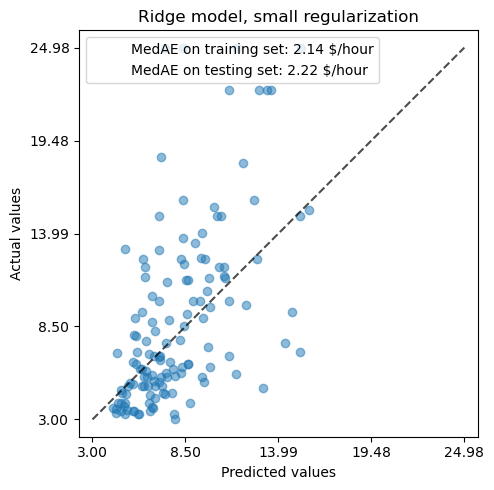

In [23]:
mae_train = median_absolute_error(y_train, model.predict(X_train))
y_pred = model.predict(X_test)
mae_test = median_absolute_error(y_test, y_pred)
scores = {
    "MedAE on training set": f"{mae_train:.2f} $/hour",
    "MedAE on testing set": f"{mae_test:.2f} $/hour",
}

_, ax = plt.subplots(figsize=(5, 5))
display = PredictionErrorDisplay.from_predictions(
    y_test, y_pred, kind="actual_vs_predicted", ax=ax, scatter_kwargs={"alpha": 0.5}
)
ax.set_title("Ridge model, small regularization")
for name, score in scores.items():
    ax.plot([], [], " ", label=f"{name}: {score}")
ax.legend(loc="upper left")
plt.tight_layout()

For the coefficient analysis, scaling is not needed this time because it was performed during the preprocessing step.

对于系数分析，这次不需要缩放，因为它是在预处理步骤中进行的。

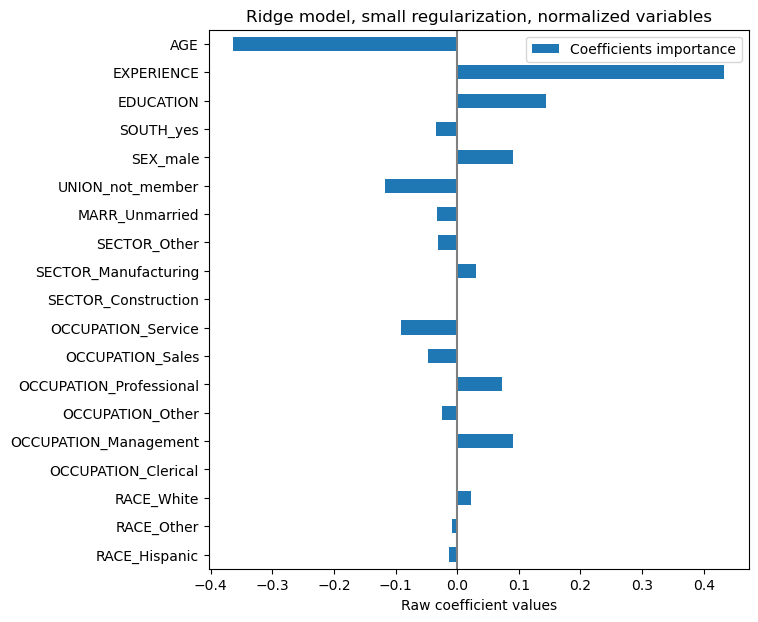

In [24]:
coefs = pd.DataFrame(
    model[-1].regressor_.coef_,
    columns=["Coefficients importance"],
    index=feature_names,
)
coefs.plot.barh(figsize=(9, 7))
plt.title("Ridge model, small regularization, normalized variables")
plt.xlabel("Raw coefficient values")
plt.axvline(x=0, color=".5")
plt.subplots_adjust(left=0.3)

现在我们来检查几个交叉验证折叠的系数。如上例所示，我们不需要按特征值的std. dev对系数进行缩放，因为这种缩放已经在管道的预处理步骤中完成了。

In [25]:
cv_model = cross_validate(
    model,
    X,
    y,
    cv=cv,
    return_estimator=True,
    n_jobs=2,
)
coefs = pd.DataFrame(
    [est[-1].regressor_.coef_ for est in cv_model["estimator"]], columns=feature_names
)

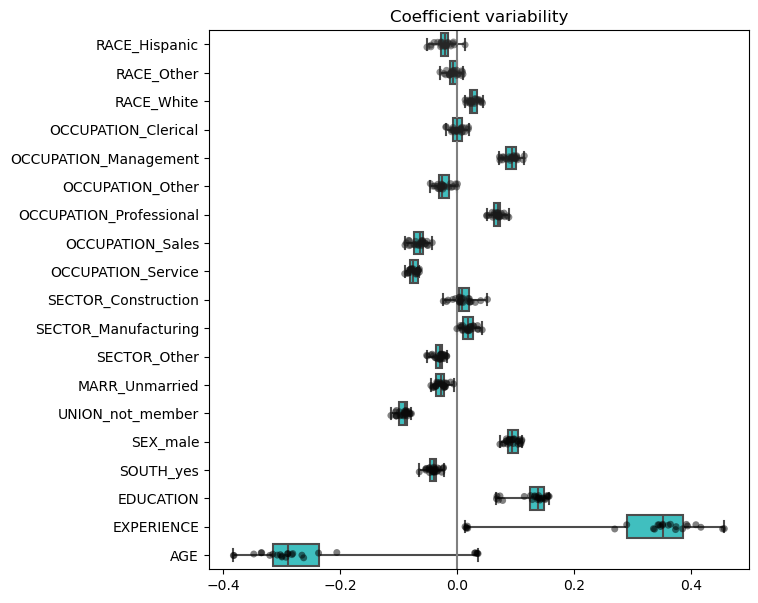

In [26]:
plt.figure(figsize=(9, 7))
sns.stripplot(data=coefs, orient="h", palette="dark:k", alpha=0.5)
sns.boxplot(data=coefs, orient="h", color="cyan", saturation=0.5, whis=10)
plt.axvline(x=0, color=".5")
plt.title("Coefficient variability")
plt.subplots_adjust(left=0.3)

The result is quite similar to the non-normalized case.

结果与非规范化情况非常相似。

## Linear models with regularization

在机器学习实践中，Ridge回归通常使用不可忽略的正则化。

上面，我们将正则化限制在很小的范围内。正则化改进了对问题的调节，减少了估计的方差。RidgeCV应用交叉验证来确定正则化参数(alpha)的哪个值最适合预测。

In [27]:
from sklearn.linear_model import RidgeCV

alphas = np.logspace(-10, 10, 21)  # alpha values to be chosen from by cross-validation
model = make_pipeline(
    preprocessor,
    TransformedTargetRegressor(
        regressor=RidgeCV(alphas=alphas),
        func=np.log10,
        inverse_func=sp.special.exp10,
    ),
)
model.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('onehotencoder',
                                                  OneHotEncoder(drop='if_binary'),
                                                  ['RACE', 'OCCUPATION',
                                                   'SECTOR', 'MARR', 'UNION',
                                                   'SEX', 'SOUTH']),
                                                 ('standardscaler',
                                                  StandardScaler(),
                                                  ['EDUCATION', 'EXPERIENCE',
                                                   'AGE'])])),
                ('transformedtargetregressor',
                 TransformedTargetRegressor(func=<ufunc 'log10'>,
                                            inverse_func=<ufunc 'exp10'>,
                                            regressor=RidgeCV(alphas=array([1.e-10, 1.e-09, 1.e-08, 1.e-07, 1.e-06, 1.e-05, 1.e-04, 1.e-03,
       1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02, 1.e+03, 1.e+04, 1.e+05,
       1.e+06, 1.e+07, 1.e+08, 1.e+09, 1.e+10]))))])

First we check which value of `α`  has been selected.

首先，我们检查选择了哪个α值。

In [28]:
model[-1].regressor_.alpha_

10.0

Then we check the quality of the predictions.

然后我们检查预测的质量。

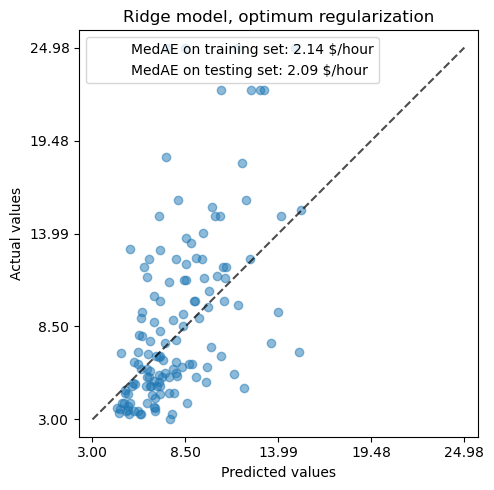

In [29]:
# 中位数绝对偏差：一种用于衡量数据集中离散程度的统计量，它是每个数据点与数据集的中位数之间的绝对差的中位数。
mae_train = median_absolute_error(y_train, model.predict(X_train))
y_pred = model.predict(X_test)
mae_test = median_absolute_error(y_test, y_pred)
scores = {
    "MedAE on training set": f"{mae_train:.2f} $/hour",
    "MedAE on testing set": f"{mae_test:.2f} $/hour",
}

_, ax = plt.subplots(figsize=(5, 5))
display = PredictionErrorDisplay.from_predictions(
    y_test, y_pred, kind="actual_vs_predicted", ax=ax, scatter_kwargs={"alpha": 0.5}
)
ax.set_title("Ridge model, optimum regularization")
for name, score in scores.items():
    ax.plot([], [], " ", label=f"{name}: {score}")
ax.legend(loc="upper left")
plt.tight_layout()

正则化模型重现数据的能力与非正则化模型相似。

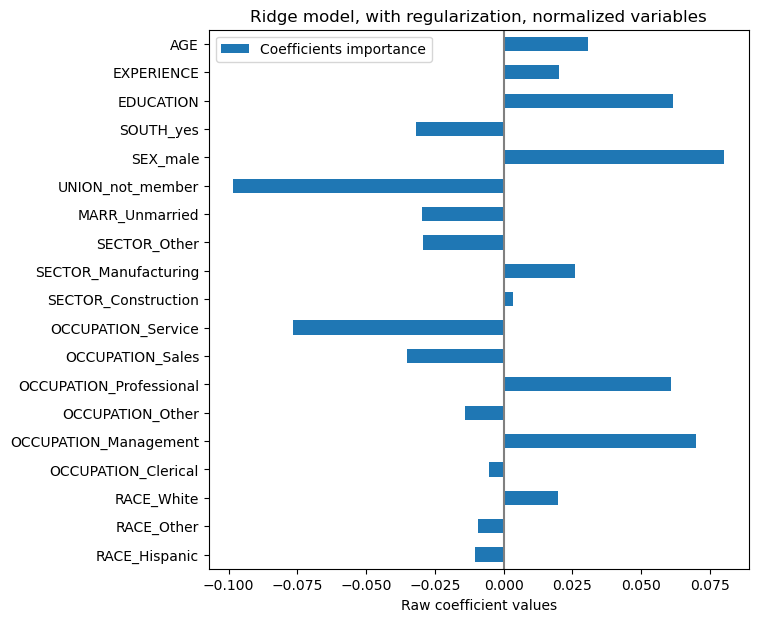

In [30]:
coefs = pd.DataFrame(
    model[-1].regressor_.coef_,
    columns=["Coefficients importance"],
    index=feature_names,
)
coefs.plot.barh(figsize=(9, 7))
plt.title("Ridge model, with regularization, normalized variables")
plt.xlabel("Raw coefficient values")
plt.axvline(x=0, color=".5")
plt.subplots_adjust(left=0.3)

系数差异很大。年龄和经验系数都是正的，但它们现在对预测的影响较小。

正则化降低了相关变量对模型的影响，因为权重在两个预测变量之间共享，所以单独的两个变量都不会有强权重。

另一方面，通过正则化得到的权重更稳定(参见岭回归和分类用户指南部分)。在交叉验证中，从从数据扰动中获得的图中可以看到这种稳定性的增加。可以将这幅图与前一幅图进行比较。

In [31]:
cv_model = cross_validate(
    model,
    X,
    y,
    cv=cv,
    return_estimator=True,
    n_jobs=2,
)
coefs = pd.DataFrame(
    [est[-1].regressor_.coef_ for est in cv_model["estimator"]], columns=feature_names
)

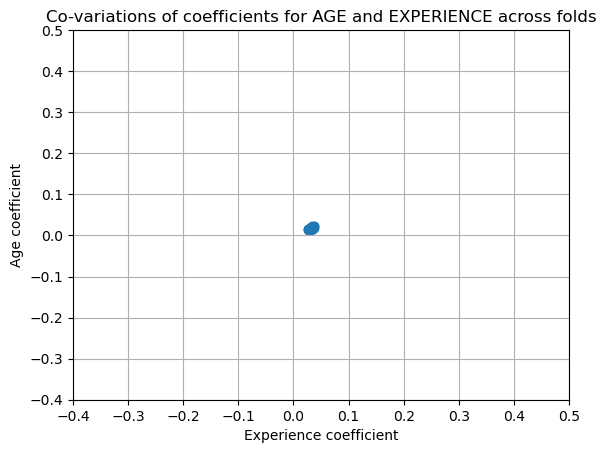

In [32]:
plt.ylabel("Age coefficient")
plt.xlabel("Experience coefficient")
plt.grid(True)
plt.xlim(-0.4, 0.5)
plt.ylim(-0.4, 0.5)
plt.scatter(coefs["AGE"], coefs["EXPERIENCE"])
_ = plt.title("Co-variations of coefficients for AGE and EXPERIENCE across folds")

## Linear models with sparse coefficients

另一种考虑数据集中相关变量的方法是估计稀疏系数。在之前的**Ridge**估计中，我们已经以某种方式手动删除了**AGE**列。

**Lasso**模型（[参见Lasso用户指南](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LassoCV.html#sklearn.linear_model.LassoCV)）估计稀疏系数。**LassoCV**应用交叉验证来确定正则化参数(alpha)的哪个值最适合模型估计。

In [33]:
from sklearn.linear_model import LassoCV

alphas = np.logspace(-10, 10, 21)  # alpha values to be chosen from by cross-validation
model = make_pipeline(
    preprocessor,
    TransformedTargetRegressor(
        regressor=LassoCV(alphas=alphas, max_iter=100_000),
        func=np.log10,
        inverse_func=sp.special.exp10,
    ),
)

_ = model.fit(X_train, y_train)

First we verify which value of `α` has been selected.

首先，我们验证选择了哪个α值。

In [34]:
model[-1].regressor_.alpha_

0.001

Then we check the quality of the predictions.

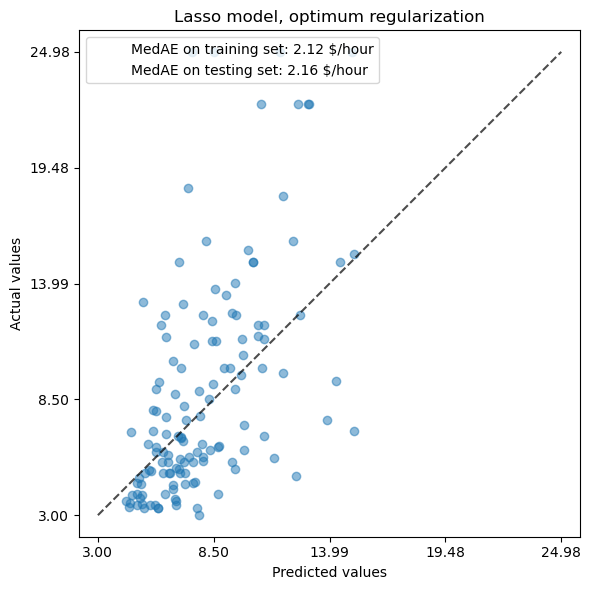

In [35]:
mae_train = median_absolute_error(y_train, model.predict(X_train))
y_pred = model.predict(X_test)
mae_test = median_absolute_error(y_test, y_pred)
scores = {
    "MedAE on training set": f"{mae_train:.2f} $/hour",
    "MedAE on testing set": f"{mae_test:.2f} $/hour",
}

_, ax = plt.subplots(figsize=(6, 6))
display = PredictionErrorDisplay.from_predictions(
    y_test, y_pred, kind="actual_vs_predicted", ax=ax, scatter_kwargs={"alpha": 0.5}
)
ax.set_title("Lasso model, optimum regularization")
for name, score in scores.items():
    ax.plot([], [], " ", label=f"{name}: {score}")
ax.legend(loc="upper left")
plt.tight_layout()

For our dataset, again the model is not very predictive.

对于我们的数据集，模型的预测能力也不强。

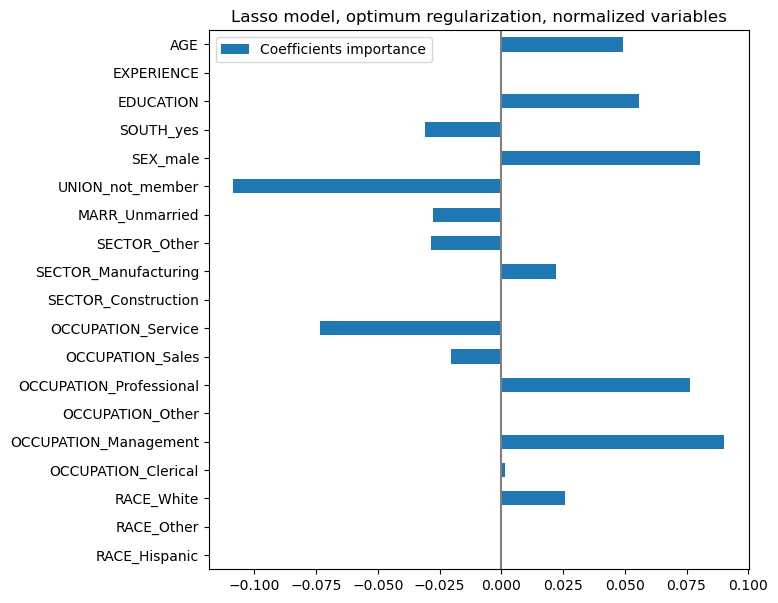

In [36]:
coefs = pd.DataFrame(
    model[-1].regressor_.coef_,
    columns=["Coefficients importance"],
    index=feature_names,
)
coefs.plot(kind="barh", figsize=(9, 7))
plt.title("Lasso model, optimum regularization, normalized variables")
plt.axvline(x=0, color=".5")
plt.subplots_adjust(left=0.3)

Lasso模型识别年龄和经验之间的相关性，并抑制其中之一以进行预测。

重要的是要记住，被删除的系数可能仍然与结果本身有关:模型选择抑制它们，因为它们在其他特征之上带来的额外信息很少或根本没有。此外，对于相关特征来说，这种选择是不稳定的，应该谨慎解释。

实际上，我们可以检查折叠中系数的可变性。

In [37]:
cv_model = cross_validate(
    model,
    X,
    y,
    cv=cv,
    return_estimator=True,
    n_jobs=2,
)
coefs = pd.DataFrame(
    [est[-1].regressor_.coef_ for est in cv_model["estimator"]], columns=feature_names
)

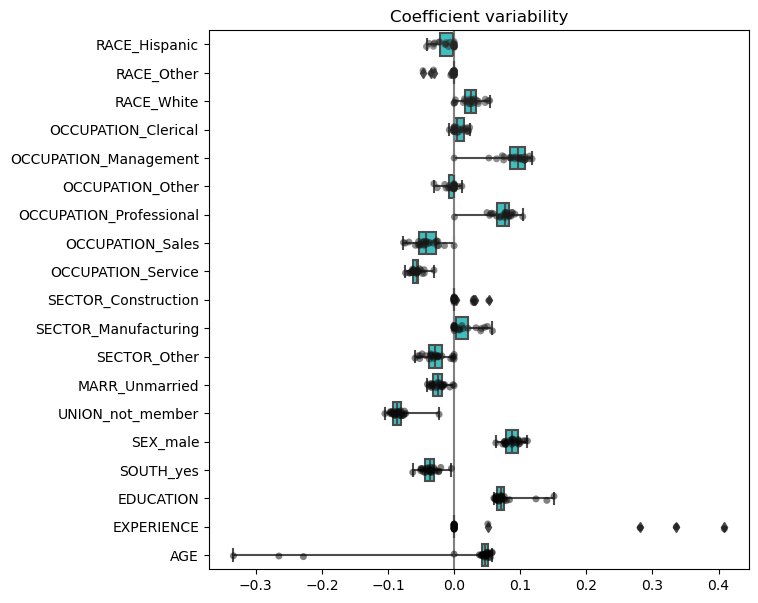

In [38]:
plt.figure(figsize=(9, 7))
sns.stripplot(data=coefs, orient="h", palette="dark:k", alpha=0.5)
sns.boxplot(data=coefs, orient="h", color="cyan", saturation=0.5, whis=100)
plt.axvline(x=0, color=".5")
plt.title("Coefficient variability")
plt.subplots_adjust(left=0.3)

我们观察到年龄和经验系数随折叠的不同有很大的变化。

## Wrong causal interpretation

错误的因果解释

政策制定者可能想知道教育对工资的影响，以评估旨在吸引人们追求更多教育的某种政策是否在经济上有意义。虽然机器学习模型很适合测量统计关联，但它们通常无法推断因果关系。

我们可能很想从上一个模型(或任何与此相关的模型)中查看教育对工资的系数，并得出结论，认为它捕捉了标准化教育变量变化对工资的真实影响。

不幸的是，可能存在一些未被观察到的混淆变量，它们会使该系数膨胀或缩小。混淆变量是同时导致教育和工资的变量。这种变量的一个例子是能力。据推测，能力越强的人更有可能追求教育，同时也更有可能在任何教育水平上获得更高的时薪。在这种情况下，能力诱发了一个正的忽略变量偏差(OVB)对教育系数，从而夸大了教育对工资的影响。



参见[能力OVB的模拟案例](https://scikit-learn.org/stable/auto_examples/inspection/plot_causal_interpretation.html#sphx-glr-auto-examples-inspection-plot-causal-interpretation-py)，机器学习无法推断因果关系

## Lessons learned

* Coefficients must be scaled to the same unit of measure to retrieve feature importance. Scaling them with the standard-deviation of the feature is a useful proxy.
* Coefficients in multivariate linear models represent the dependency between a given feature and the target, conditional on the other features.
* Correlated features induce instabilities in the coefficients of linear models and their effects cannot be well teased apart.
* Different linear models respond differently to feature correlation and coefficients could significantly vary from one another.
* Inspecting coefficients across the folds of a cross-validation loop gives an idea of their stability.
* Coefficients are unlikely to have any causal meaning. They tend to be biased by unobserved confounders.
* Inspection tools may not necessarily provide insights on the true data generating process.

## 经验教训

* 系数必须缩放到相同的度量单位，以检索特征重要性。用特性的标准差对它们进行缩放是一个有用的代理。
* 多元线性模型中的系数表示给定特征与目标之间的依赖关系，依赖于其他特征。
* 相关特征导致线性模型系数的不稳定性，并且它们的影响不能很好地分离。
* 不同的线性模型对特征相关性的响应不同，不同线性模型的系数可能存在显著差异。
* 通过检查交叉验证循环中折线上的系数，可以了解它们的稳定性。
* 系数不太可能具有任何因果意义。它们往往会受到未观察到的混杂因素的影响。
* 检查工具不一定能提供真实数据生成过程的信息。